In [3]:
import torch
import torchvision.utils
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [51]:
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.AutoAugment(),
    # transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.RandomResizedCrop((400, 400), scale=(0.3,1)),
    # transforms.RandomAdjustSharpness(0.3),
    transforms.RandomAffine(30, (0.2, 0.2), (0.5, 1), fill=[1.2164, 0.9352, 0.4382]),
    transforms.Resize((256, 256)),

    transforms.ToTensor(),
    # transforms.RandomErasing(0.2),
    #transforms.Normalize(mean=[1.2164, 0.9352, 0.4382], std=([1.7961, 1.5757, 1.6312]))
])

output_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[1.2164, 0.9352, 0.4382], std=([1.7961, 1.5757, 1.6312]))
])

training_data = datasets.Flowers102(root="data", split="train", download=True, transform=input_transform)
validation_data = datasets.Flowers102(root="data", split="val", download=True, transform=output_transform)
test_data = datasets.Flowers102(root="data", split="test", download=True, transform=output_transform)

SyntaxError: positional argument follows keyword argument (1069887872.py, line 5)

In [ ]:
len(training_data), len(validation_data), len(test_data)

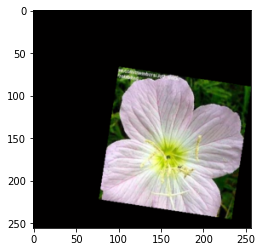

In [49]:
plt.imshow(training_data[1][0].permute(1, 2, 0))

In [ ]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
import torch_directml
dml = torch_directml.device()
torch_directml.device_name(0)
torch_directml.is_available()
#AMD WORKAROUND: DO NOT SUBMIT

In [ ]:
device = dml
torch.cuda.empty_cache()

class FlowersModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(32 * 32 * 32, 256)
        self.batch_norm4 = nn.BatchNorm1d(256)
        self.final = nn.Linear(256, 102)
        self.softmax = nn.LogSoftmax(dim=1)
        self.output = nn.Sequential(
            self.conv1,
            self.relu,
            self.batch_norm1,
            self.pool2,
            self.conv2,
            self.relu,
            self.batch_norm2,
            self.pool2,
            self.conv3,
            self.relu,
            self.batch_norm3,
            self.pool2,
            self.flatten,
            self.dropout,
            self.linear,
            self.relu,
            self.batch_norm4,
            self.dropout,
            self.final,
            self.softmax
        )

    def forward(self, x):
        return self.output(x)

    def get_first_conv_output(self, x):
        return self.relu(self.conv1(x))

    def get_second_conv_output(self, x):
        x = self.relu(self.conv1(x))
        return self.relu(self.conv2(self.pool1(x)))

    def get_third_conv_output(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(self.pool1(x)))
        return self.relu(self.conv3(self.pool2(x)))

model = FlowersModel().to(device)
model

In [ ]:
learning_rate = 0.0005
loss_fn = nn.NLLLoss()
optimiser = torch.optim.AdamW(model.parameters(), learning_rate)

In [ ]:
def train(dataloader: DataLoader, training_model: nn.Module, optim: torch.optim.Optimizer):
    size = len(dataloader.dataset)
    training_model.train()
    for batch_no, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred = training_model(X)
        # actual = nn.functional.one_hot(y, 102)
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        loss = loss_fn(pred, y)
        loss.backward()
        optim.step()

        if batch_no % 10 == 0:
            loss, current = loss.item(), (batch_no + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}], accuracy: {correct/len(y) * 100}")

def test(dataloader:DataLoader, eval_model: nn.Module, losses: list, accuracy: list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = eval_model(X)
            # actual = nn.functional.one_hot(y, 102)
            total_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    total_loss /= num_batches
    correct /= size

    losses.append(total_loss)
    accuracy.append(100 * correct)

    print(f"Accuracy: {(100 * correct):>0.1f}%, Avg loss: {total_loss:>8f} \n")


In [ ]:
#max_model = torch.load("model-maximum.pth")
#max_accuracy = test(test_dataloader, max_model, [], [] )
max_accuracy=0

In [ ]:
val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []
epoch_list = []

In [ ]:
epochs = 240


for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, optimiser)
    epoch_list.append(t+1)
    print("Validation Error:")
    accuracy = test(val_dataloader, model, val_losses, val_accuracy)
    if(accuracy > max_accuracy):
        secondAccuracy = test(test_dataloader, model, [], [])
        if(secondAccuracy > max_accuracy):
            max_accuracy = secondAccuracy
            torch.save(model, "model-maximum.pth")
    print("Training Error:")
    test(train_dataloader, model, train_losses, train_accuracy)

    # epoch_list.append(t)

print("Done!")

#Note to self, try calculate FULl dataset noramlisation values not just test set


In [ ]:
print("Testing error:")
test(test_dataloader, model, [], [])

In [ ]:
sns.set()
# epoch_list.append(31)
f, ax = plt.subplots(2, 1)
# ax[0].plot(epoch_list, test_accuracy)
ax[0].plot(val_accuracy)
ax[0].plot(train_accuracy)
ax[0].set_ylim(0, 100)
# ax[1].plot(epoch_list, test_losses)
ax[1].plot(val_losses)
ax[1].plot(train_losses)
ax[1].set_ylim(0, 5)
# f.show()

In [ ]:
torch.save(model, "model-inprogress.pth")
print("Saved PyTorch Model State to model.pth")


In [ ]:
model_state_dict = torch.load("./model-inprogress.pth")
model_state_dict

In [ ]:
single_dataloader = DataLoader(test_data, 1, shuffle=True)
with torch.no_grad():
    for x, y in single_dataloader:
        x, y = x.to(device), y.to(device)
        first_conv = model.get_first_conv_output(x)
        second_conv = model.get_second_conv_output(x)
        third_conv = model.get_third_conv_output(x)
        pred = model(x)
        break

In [ ]:
plt.imshow(x[0].to("cpu").permute(1, 2, 0))

In [ ]:
# print(pred[0].argmax(), y[0])
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
plt.rcParams["savefig.bbox"] = 'tight'
f, ax = plt.subplots(4, 4, squeeze=False)
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(4):
    for j in range(4):
        img = to_pil_image(first_conv.to("cpu")[0][i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


In [ ]:
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
f, ax = plt.subplots(4, 4, squeeze=False)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(4):
    for j in range(4):
        img = to_pil_image(second_conv.to("cpu")[0][i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torchvision.transforms.functional import to_pil_image
plt.tight_layout()
f, ax = plt.subplots(4, 4, squeeze=False)
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(4):
    for j in range(4):
        img = to_pil_image(second_conv.to("cpu")[0][16 + i * 4 + j])
        ax[i, j].imshow(img)
        ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])